In [1]:
%load_ext autoreload
%autoreload 3 --print
# import os; os.environ['JAX_PLATFORM_NAME'] = 'cpu'
# import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'

In [2]:
from shape_norm.project.paths import Project, create_model
from shape_norm.io import loaders
from shape_norm.models import joint
from shape_norm import config
from shape_norm.models import instantiation, setup, pose, morph, util as model_util
from shape_norm import fitting
from shape_norm.fitting import em
from shape_norm.io import alignment, features
from shape_norm.io.armature import Armature
from shape_norm.fitting import methods
from shape_norm.fitting import scans
from shape_norm.pca import fit_with_center, CenteredPCA
from shape_norm.io.dataset_refactor import Dataset
from shape_norm.models.morph.lowrank_affine import LRAParams, model as lra_model
import os, sys, shutil
import numpy as np
from pprint import pprint
import jax.numpy as jnp
from shape_norm import viz
import optax
import jax
from shape_norm.viz import styles
from bidict import bidict
import matplotlib.pyplot as plt
from collections import defaultdict
import os, re
import tqdm
from cmap import Colormap
import joblib as jl

from pathlib import Path
import logging
logging.getLogger().setLevel(logging.INFO)

### Dataset generation functions

In [3]:
# From unit-tests.ipynb

def create_dataset_2d(
    sessions,
    bodies,
    session_bodies,
    n_frames,
    n_components,
    weights,
    means,
    covs,
    transform_matrices,
    transform_biases,
    ref_session=None,
    keypoint_names=None,
    seed=None,
):
    """
    Create a dictionary of keyword arguments for creating a project from a 2D
    test dataset.

    Args:
        sessions (list):
            The number of sessions in the model.
        bodies (list):
            The number of bodies in the model.
        session_bodies (dict):
            A mapping of session names to body names.
        n_frames (int):
            Number of samples to generate for each session.
        n_components (int):
            The number of components in the model.
        weights (np.ndarray, shape (n_sessions, n_components,)):
            The weights of the model, ordered as the list of session names.
        means (np.ndarray, shape (n_components, 2)):
            The means of the Gaussian componets.
        covs (np.ndarray, shape (n_components, 2, 2)):
            The covariances of the Gaussian componets.
        transform_matrices (np.ndarray, shape (n_sessions, 2, 2)):
            The transformation matrices of the affine morph to be applied to the
            data generated by the mixture model.
        transform_biases (np.ndarray, shape (n_sessions, 2)):
            The transformation biases of the affine morph.
        ref_session : str
            The reference session name or `None` to select the first session.
        keypoint_names (list):
            The names of the dimensions of the model data, or `None` to use
            integer indices (converted to strings).
        seed (int):
            The random seed to use for generating the data.

    Returns:
        project_config_kws (dict):
            A dictionary of keyword arguments for creating a project, containing
            keys 'session_names`, `bodies`, `ref_session`.
        raw_keypoints (dict):
            A dictionary of raw keypoint data, containing a key for each
            session name mapping to data of shape (n_frames, 2, 1)
        component_ids (dict):
            A dictionary of arrays containing the component index of each frame
            for each session.
    """

    # convert parameters to arrays
    weights = np.array(weights)
    means = np.array(means)
    covs = np.array(covs)
    transform_matrices = np.array(transform_matrices)
    transform_biases = np.array(transform_biases)

    # check sum to 1 and psd
    assert np.allclose(weights.sum(axis=1), 1)
    assert np.all(np.linalg.eigvals(covs) > 0)

    # setup
    n_bodies = len(bodies)
    n_sessions = len(sessions)
    rng = np.random.default_rng(seed)
    ref_session = ref_session or sessions[0]
    keypoint_names = keypoint_names or [str(i) for i in range(2)]
    keypoint_parents = [None] + [k for k in keypoint_names[:-1]]

    # sample component IDs
    component_ids = {
        s: rng.choice(n_components, size=n_frames, p=weights[i])
        for i, s in enumerate(sessions)
    }
    # sample gaussian noise and transform according to component IDs
    poses = {
        s: np.einsum(
            "ijk,ik->ij",
            np.linalg.cholesky(covs)[component_ids[s]],
            rng.multivariate_normal(np.zeros(2), np.eye(2), size=n_frames),
        )
        + means[component_ids[s]]
        for s in sessions
    }
    # apply affine transform
    observations = {
        s: (np.einsum("ij,aj->ai", transform_matrices[i], poses[s])
        + transform_biases[i])[..., None]
        for i, s in enumerate(sessions)
    }

    # create project config
    project_config_kws = {
        "session_names": sessions,
        "bodies": session_bodies,
        "ref_session": ref_session,
        "keypoint_names": keypoint_names,
        "keypoint_parents": keypoint_parents,
    }

    return project_config_kws, observations, component_ids


def random_lra_morphed(
    n_bodies,
    n_dims,
    n_noise_dims,
    centroid_scale,
    mode_scale,
    data,
    session_names,
    seed=0,
    normalize_mode_upd=False,
):
    """
    Generate a dataset with copies of given data altered according to a random
    low-rank affine morph.

    The morph is generated by finding the PCs of `data` and then sampling
    additive gaussian noise updates the centroid and PCs. This noise is sampled
    from the first `n_noise_dims` PCs of the data.

    Args:
        n_bodies (int):
            The number of bodies in the model.
        n_dims (int):
            The number of PCs the morph should alter in the data.
        n_noise_dims (int):
            The number of PCs of the data the gaussian noise should stray over.
            (sets the number of PCs that feature reduction should keep)
        centroid_scale (float):
            The standard deviation of normal distribution from which to sample
            the centroid of the morphs.
        mode_scale (float):
            The standard deviation of normal distribution from which to sample
            the mode differences in the morphs.
        data (jax array, shape (n_frames, n_keypoints, n_dims)):
        session_names (list):
            Names for the sessions to generate.
        seed (int):
            The random seed to use for generating the data.
        normalize_mode_upd (bool):
            If True, normalize the mode updates to have deterministic length
            `mode_scale`.

    Returns:
        project_config_kws (dict):
            A dictionary of keyword arguments for creating a project, containing
            keys 'session_names`, `bodies`, `ref_session`.
        dataset_keypoints (dict):
            A dictionary of raw keypoint data, containing a key for each
            session name mapping to data of shape (n_frames, n_keypoints, n_spatial)
        params (LRAParams):
            The parameters of the morph.
        true_body_ids (dict):
            A dictionary mapping session names to body ids in `params`.s
    """

    # preprocess inputs
    n_bodies = len(session_names)
    rng = np.random.default_rng(seed)
    features = data.reshape(data.shape[0], -1)
    n_feats = features.shape[1]
    kp_spatial = data.shape[1:]

    # find centroid and dimensions of reference session to morph
    pca = fit_with_center(features)
    centroid = pca._center
    modes = pca._pcadata.pcs()[:n_dims].T

    # sample updates to the centroid and modes in PC space
    centroid_upds = rng.normal(
        scale=centroid_scale, size=(n_bodies, n_noise_dims)
    )
    modes_upds = rng.normal(
        scale=mode_scale, size=(n_bodies, n_noise_dims, n_dims)
    )
    if normalize_mode_upd:
        mode_norm = np.linalg.norm(modes_upds, axis=1, keepdims=True)
        modes_upds = mode_scale * modes_upds / mode_norm
    # translate noise to the full space (first pad with zeros)
    centroid_upds = np.concatenate(
        [centroid_upds, np.zeros((n_bodies, n_feats - n_noise_dims))], axis=1
    )
    modes_upds = np.concatenate(
        [modes_upds, np.zeros((n_bodies, n_feats - n_noise_dims, n_dims))],
        axis=1,
    )
    centroid_upds = pca._pcadata.from_coords(centroid_upds)
    modes_upds = pca._pcadata.from_coords(
        modes_upds.transpose(0, 2, 1)
    ).transpose(0, 2, 1)

    # create a dataset containing copies of the ref session
    # first give each session its own body to automatically assign body ids
    # then update to set the assigned body of each session to the ref body
    canonicalized = Dataset.from_arrays(
        {s: features for s in session_names},
        bodies={s: f"body-{s}" for s in session_names},
        ref_session=session_names[0],
    )
    canonicalized = canonicalized.update(
        session_meta=canonicalized.session_meta.update(
            session_bodies={
                s: f"body-{session_names[0]}" for s in session_names
            }
        ),
    )
    true_body_ids = {
        s: canonicalized.body_id(f"body-{s}") for s in session_names
    }

    # form parameters and apply them to the data
    params = morph.lowrank_affine.LRAParams(
        {
            "n_dims": n_dims,
            "n_bodies": n_bodies,
            "n_feats": n_feats,
            "ref_body": canonicalized.body_id(f"body-{session_names[0]}"),
            "prior_mode": "distance",
            "upd_var_modes": 0.0,
            "upd_var_ofs": 0.0,
            "dist_var": 0.0,
            "modes": jnp.array(modes),
            "offset": jnp.array(centroid),
            "_mode_updates": jnp.array(modes_upds),
            "_offset_updates": jnp.array(centroid_upds),
        }
    )
    observations = model_util.apply_bodies(
        morph.lowrank_affine.model,
        params,
        canonicalized,
        {s: f"body-{s}" for s in canonicalized.sessions},
    )
    dataset_keypoints = {
        s: observations.get_session(s).reshape((-1,) + kp_spatial)
        for s in session_names
    }

    # create project config
    project_config_kws = {
        "session_names": observations.sessions,
        "bodies": {
            s: observations.session_body_name(s) for s in observations.sessions
        },
        "ref_session": observations.session_name(observations.ref_session),
    }

    return (
        project_config_kws,
        dataset_keypoints,
        (params, true_body_ids),
    )


def random_lra_2d(        
    sessions,
    n_frames,
    n_components,
    weights,
    means,
    covs,
    n_morph_dims,
    n_noise_dims,
    centroid_scale,
    mode_scale,
    ref_session=None,
    keypoint_names=None,
    seed=None,
):
    """
    Generate a 2D dataset with a random low-rank affine morph applied.

    Parameters:
    See `create_dataset_2d` and `random_lra_morphed` for details.
    """
    ref_session = sessions[0] if ref_session is None else ref_session
    project_config_2d, raw_2d, component_ids = create_dataset_2d(
        sessions=[ref_session],
        bodies=["id"],
        session_bodies={ref_session: "id"},
        n_frames=n_frames,
        n_components=n_components,
        weights=weights,
        means=means,
        covs=covs,
        transform_matrices=[[[1, 0], [0, 1]]],
        transform_biases=[[0, 0]],
        ref_session=ref_session,
        keypoint_names=keypoint_names,
        seed=seed,
    )

    project_config_lra, dataset_keypoints, (params, body_ids) = (
        random_lra_morphed(
            len(sessions),
            n_morph_dims,
            n_noise_dims,
            centroid_scale,
            mode_scale,
            raw_2d[ref_session],
            sessions,
            seed=seed + 1,
        )
    )
    project_config_lra["keypoint_names"] = project_config_2d["keypoint_names"]
    project_config_lra["keypoint_parents"] = project_config_2d[
        "keypoint_parents"
    ]

    return (
        project_config_lra,
        dataset_keypoints,
        (params, body_ids, component_ids),
)


### Dataset generation

In [28]:
project_config_kws, dataset_keypoints, (true_params, true_body_ids, component_ids) = random_lra_2d(
    sessions = ["A", "B", "C"],
    n_frames = 300,
    n_components = 3,
    weights = np.array([[4, 1, 1], [1, 1, 4]]) / 6,
    means = [
        [1, 0],
        [0, 1],
        [-1, 0]
    ],
    covs = np.array([
        [[1, 0.8], [0.8, 1]],
        [[1, 0], [0, 1]],
        [[1, -0.8], [-0.8, 1]],
    ]) / 9,
    n_morph_dims=1,
    n_noise_dims=1,
    centroid_scale=0.5,
    mode_scale=0.5,
    ref_session = "A",
    keypoint_names = None,
    seed = 0,
)
component_ids = {s: component_ids["A"] for s in dataset_keypoints}

### Optimization problem

Let $X, X_n \in \mathbb{R}^{N\times K}$ be matrix of $K$ column-wise reference and target animal data points respectively. We seek a map $M\in \mathbb{R}^{N \times N}$ that best aligns the covariance structure of $MX$ with that of $X_n$ that is (a) low rank and (b) does not drastically alter the data.
Let $P\Sigma P^T$ be the SVD of the reference covariance $XX^T$. To satisfy the rank condition, we parameterize $M$ as $(P + \hat P)P^T$ for $\hat P$ with only the first $L$ columns nonzero. That is, we proceed by solving $$\begin{align*}
\arg\min_{\hat P}\left |(P+\hat P)P^T XX^TP(P + \hat P)^T - X_nX_n^T\right| &= 
\arg\min_{\hat P}\left |(P+\hat P)\Sigma^2(P + \hat P)^T - X_nX_n^T\right|
\end{align*}.$$
If the chosen matrix norm is unitarily invariant (e.g. Frobenius) then the problem further simplifies in terms of the SVD $X_nX_n^T = Q\Gamma Q^T$ as $$\begin{align*}
\arg\min_{\hat P}\left|Q^T(P+\hat P)\Sigma^2(P + \hat P)^TQ - \Gamma^2 \right|
\end{align*}$$To avoid large rotations we add $\alpha |\hat{P}|$ to the minimization.

In [8]:


def objective(ref_data, alt_data, n_upd, alpha = 0, centered = False):
    """
    Parameters:
    ref_pc, alt_pc : jnp.ndarray, shape (..., n_dims, n_pc = n_dims)
        The principal components of the reference and alternative data.
    ref_sigma, alt_sigma : jnp.ndarray, shape (..., n_pc = n_dims)
        The singular values of the reference and alternative data.
    ref_data, alt_data : jnp.ndarray, shape (..., n_samples, n_dims)
        The reference and alternative datasets, with samples arranged in rows.
    n_upd : int
        The number of principal components allowed to update
    """
    T = lambda x: jnp.swapaxes(x, -2, -1)
    if not centered:
        ref_data = ref_data - ref_data.mean(axis=-2, keepdims=True)
        alt_data = alt_data - alt_data.mean(axis=-2, keepdims=True)
    ref_cov = T(ref_data) @ ref_data / ref_data.shape[-2]
    ref_pc, _, _ = jnp.linalg.svd(ref_cov)
    ref_cov_pc = T(ref_pc) @ ref_cov @ ref_pc
    alt_cov = T(alt_data) @ alt_data / alt_data.shape[-2]
    const_pc = ref_pc[..., n_upd:]
    result_shape = jnp.broadcast_shapes(ref_data.shape[:-2], alt_data.shape[:-2])
    const_pc = jnp.broadcast_to(const_pc, result_shape + const_pc.shape[-2:])

    @jax.jit
    def _objective(upds):
        """
        Parameters:
        upds : jnp.ndarray, shape (..., n_dims, n_upd <= n_dims)
            The updates to the principal components.
        """
        # P[:n_upd] + P_hat[:n_upd]
        updated = (ref_pc[..., :n_upd] + upds)
        # P + P_hat
        updated = jnp.concatenate([updated, const_pc], axis=-1)
        # (P + P_hat) Pt X Xt P (P + P_hat)^t
        morphed = updated @ ref_cov_pc @ T(updated)
        reg = alpha * (upds ** 2).mean()
        return ((morphed - alt_cov) ** 2).mean() + reg

    def transform_from_upds(upds):
        updated = (ref_pc[..., :n_upd] + upds)
        updated = jnp.concatenate([updated, const_pc], axis=-1)
        return updated @ T(ref_pc)

    return ref_pc, _objective, transform_from_upds

In [121]:
ref_data = jnp.array([dataset_keypoints["A"]]).reshape(1, -1, 2)
alt_data = jnp.array([dataset_keypoints[k] for k in "BC"]).reshape(2, -1, 2)

ref_data -= ref_data.mean(axis=-2, keepdims=True)
alt_data -= alt_data.mean(axis=-2, keepdims=True)

lr = 1e-2
n_upd = 1
alpha = 0
opt = optax.adam(learning_rate = lr)
_, obj, transform_from_upds = objective(ref_data, alt_data, n_upd, alpha)
n_dim = ref_data.shape[-1]
upds_init = jnp.zeros(alt_data.shape[:-2] + (n_dim, n_upd,))

n_steps = 1000
ckpt_every = 10
losses = np.zeros(n_steps)
upds_hist = np.zeros((n_steps // ckpt_every, *upds_init.shape))
upds_curr = upds_init
opt_state = opt.init(upds_init)

for i in tqdm.trange(n_steps):
    loss, grad = jax.value_and_grad(obj)(upds_curr)
    losses[i] = loss
    param_step, opt_state = opt.update(grad, opt_state)
    upds_curr = optax.apply_updates(upds_curr, param_step)
    if i % ckpt_every == 0:
        upds_hist[i // ckpt_every] = np.array(upds_curr)

100%|██████████| 1000/1000 [00:00<00:00, 1157.78it/s]


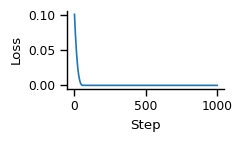

In [122]:
fig, ax = plt.subplots(figsize = (2.5, 1.5))
ax.plot(losses)
ax.set_xlabel("Step")
ax.set_ylabel("Loss")
plotter.finalize(fig, None)


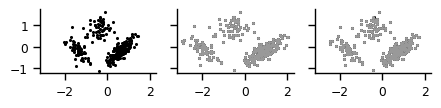

In [126]:
transform = transform_from_upds(upds_curr) # (batch, out, in)
transformed = transform @ jnp.swapaxes(ref_data, -2, -1) # (batch, out, n_samples)
fig, ax = plt.subplots(1, 3, figsize = (4.5, 1.5), sharex=True, sharey=True)
ax[0].scatter(*ref_data[0].T, s = 2, color = 'k')
ax[1].scatter(*alt_data[0].T, s = 2, color = 'k')
ax[1].scatter(*transformed[0], s = 2, color ='.6')
ax[2].scatter(*alt_data[1].T, s = 2, color = 'k')
ax[2].scatter(*transformed[1], s = 2, color ='.6')
for a in ax:
    a.set_aspect('equal')
plotter.finalize(fig, None)

### Orthogonal complement form

In [77]:


def objective_ortho(ref_data, alt_data, n_upd, alpha = 0, centered = False, ref_pc = None):
    """
    Parameters:
    ref_data, alt_data : jnp.ndarray, shape (..., n_samples, n_dims)
        The reference and alternative datasets, with samples arranged in rows.
    n_upd : int
        The number of principal components allowed to update
    """
    T = lambda x: jnp.swapaxes(x, -2, -1)
    if not centered:
        ref_data = ref_data - ref_data.mean(axis=-2, keepdims=True)
        alt_data = alt_data - alt_data.mean(axis=-2, keepdims=True)
    ref_cov = T(ref_data) @ ref_data / ref_data.shape[-2]
    if ref_pc is None:
        ref_pc, _, _ = jnp.linalg.svd(ref_cov)
        ref_pc = ref_pc[..., :n_upd]
    else:
        n_upd = ref_pc.shape[-1]
    alt_cov = T(alt_data) @ alt_data / alt_data.shape[-2]
    N = ref_data.shape[-1]
    I = jnp.eye(N).reshape((1,) * (ref_data.ndim - 2) + (N, N))
    
    @jax.jit
    def _objective(upds):
        """
        Parameters:
        upds : jnp.ndarray, shape (..., n_dims, n_upd <= n_dims)
            The updates to the principal components.
        """
        # P[:n_upd] + P_hat[:n_upd]
        updated = (I + upds @ T(ref_pc))
        # P + P_hat
        # (I + P_hat P') X X' (I + P P_hat')
        morphed = updated @ ref_cov @ T(updated)
        reg = alpha * (upds ** 2).mean()
        return ((morphed - alt_cov) ** 2).mean() + reg

    def transform_from_upds(upds):
        return (I + upds @ T(ref_pc))

    return ref_pc, _objective, transform_from_upds

In [78]:
ref_data = jnp.array([dataset_keypoints["A"]]).reshape(1, -1, 2)
alt_data = jnp.array([dataset_keypoints[k] for k in "BC"]).reshape(2, -1, 2)

ref_data -= ref_data.mean(axis=-2, keepdims=True)
alt_data -= alt_data.mean(axis=-2, keepdims=True)

lr = 1e-2
n_upd = 1
alpha = 0
opt = optax.adam(learning_rate = lr)
_, obj, transform_from_upds = objective_ortho(ref_data, alt_data, n_upd, alpha)
n_dim = ref_data.shape[-1]
upds_init = jnp.zeros(alt_data.shape[:-2] + (n_dim, n_upd,))

n_steps = 1000
ckpt_every = 10
losses = np.zeros(n_steps)
upds_hist = np.zeros((n_steps // ckpt_every, *upds_init.shape))
upds_curr = upds_init
opt_state = opt.init(upds_init)

for i in tqdm.trange(n_steps):
    loss, grad = jax.value_and_grad(obj)(upds_curr)
    losses[i] = loss
    param_step, opt_state = opt.update(grad, opt_state)
    upds_curr = optax.apply_updates(upds_curr, param_step)
    if i % ckpt_every == 0:
        upds_hist[i // ckpt_every] = np.array(upds_curr)

100%|██████████| 1000/1000 [00:00<00:00, 1081.86it/s]


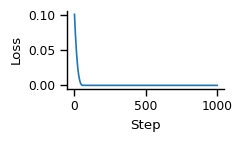

In [72]:
fig, ax = plt.subplots(figsize = (2.5, 1.5))
ax.plot(losses)
ax.set_xlabel("Step")
ax.set_ylabel("Loss")
plotter.finalize(fig, None)


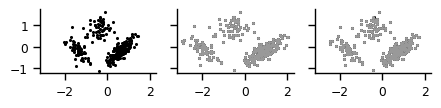

In [73]:
transform = transform_from_upds(upds_curr) # (batch, out, in)
transformed = transform @ jnp.swapaxes(ref_data, -2, -1) # (batch, out, n_samples)
fig, ax = plt.subplots(1, 3, figsize = (4.5, 1.5), sharex=True, sharey=True)
ax[0].scatter(*ref_data[0].T, s = 2, color = 'k')
ax[1].scatter(*alt_data[0].T, s = 2, color = 'k')
ax[1].scatter(*transformed[0], s = 2, color ='.6')
ax[2].scatter(*alt_data[1].T, s = 2, color = 'k')
ax[2].scatter(*transformed[1], s = 2, color ='.6')
for a in ax:
    a.set_aspect('equal')
plotter.finalize(fig, None)

### With preset morph dimensions

With the same dataset, in which sessions are morphed by stretching the axis $[1,
0]$, prescribe the morphable dimension to be $[1, 1]$. The correct solution
should be some skew of the data. 

In [79]:
ref_data = jnp.array([dataset_keypoints["A"]]).reshape(1, -1, 2)
alt_data = jnp.array([dataset_keypoints[k] for k in "BC"]).reshape(2, -1, 2)

ref_data -= ref_data.mean(axis=-2, keepdims=True)
alt_data -= alt_data.mean(axis=-2, keepdims=True)

lr = 1e-2
n_upd = 1
alpha = 0
opt = optax.adam(learning_rate = lr)
modes = jnp.array([1, 1]).reshape(2, 1)
_, obj, transform_from_upds = objective_ortho(ref_data, alt_data, n_upd, alpha, ref_pc = modes)
n_dim = ref_data.shape[-1]
upds_init = jnp.zeros(alt_data.shape[:-2] + (n_dim, n_upd,))

n_steps = 1000
ckpt_every = 10
losses = np.zeros(n_steps)
upds_hist = np.zeros((n_steps // ckpt_every, *upds_init.shape))
upds_curr = upds_init
opt_state = opt.init(upds_init)

for i in tqdm.trange(n_steps):
    loss, grad = jax.value_and_grad(obj)(upds_curr)
    losses[i] = loss
    param_step, opt_state = opt.update(grad, opt_state)
    upds_curr = optax.apply_updates(upds_curr, param_step)
    if i % ckpt_every == 0:
        upds_hist[i // ckpt_every] = np.array(upds_curr)

100%|██████████| 1000/1000 [00:00<00:00, 1177.14it/s]


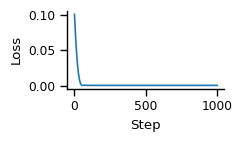

In [80]:
fig, ax = plt.subplots(figsize = (2.5, 1.5))
ax.plot(losses)
ax.set_xlabel("Step")
ax.set_ylabel("Loss")
plotter.finalize(fig, None)


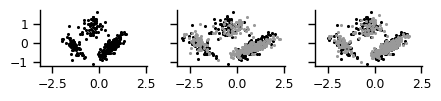

In [81]:
transform = transform_from_upds(upds_curr) # (batch, out, in)
transformed = transform @ jnp.swapaxes(ref_data, -2, -1) # (batch, out, n_samples)
fig, ax = plt.subplots(1, 3, figsize = (4.5, 1.5), sharex=True, sharey=True)
ax[0].scatter(*ref_data[0].T, s = 2, color = 'k')
ax[1].scatter(*alt_data[0].T, s = 2, color = 'k')
ax[1].scatter(*transformed[0], s = 2, color ='.6')
ax[2].scatter(*alt_data[1].T, s = 2, color = 'k')
ax[2].scatter(*transformed[1], s = 2, color ='.6')
for a in ax:
    a.set_aspect('equal')
plotter.finalize(fig, None)

### Place within user friendly function

In [17]:
def _check_should_stop_early(loss_hist, step_i, tol, stop_window):
    """
    Check for median decrease in loss that is worse than `tol`.

    Args:
        loss_hist: np.ndarray, shape: (N,)
            Last `N` observations of loss.
        tol: Scalar
            Required average improvement to continue.
    """
    if tol is not None and step_i > stop_window:
        loss_hist = loss_hist[step_i - stop_window : step_i + 1]
        diff = np.diff(loss_hist)
        median = np.median(diff)
        return median > -tol
    return False

def maximal_pc_align(ref_data, alt_data, n_upd, alpha = 1e-3, lr = 1e-2, max_iter = 5000, stop_window = 100, tol = 1e-5, progress = False):
    """
    Parameters
    ----------
    ref_data : jnp.ndarray, shape (samples, features)
        The reference data to map onto alternative covariance structures.
    alt_data : jnp.ndarray, shape (n_alts, samples, features)
        The alternative data to map onto.
    n_upd : int
        The number of principal components to update.
    alpha : float
        The regularization strength.
    lr : float
        The learning rate.
    max_iter : int
        The maximum number of iterations.
    tol, stop_window : int
        The criteria for early stopping: if loss has not decreased by more than
        `tol` for `stop_window` steps, stop early.
    progress : bool
        Whether to display a progress bar.

    Returns
    -------
    ref_center, alt_center : jnp.ndarray, shapes (features,) and (n_alts, features)
        The means of the reference and alternative datasets.
    ref_pc : jnp.ndarray, shape (features, n_pc)
        The principal components of the reference data.
    upds_best : jnp.ndarray, shape (n_alts, features, n_upd)
        The best updates to the principal components.
    """

    ref_center = ref_data.mean(axis = 0)
    alt_center = alt_data.mean(axis = 1)
    ref_data = ref_data[None] - ref_center[None, None] # shape: (1, samples, features)
    alt_data = alt_data - alt_center[:, None] # shape: (n_alts, samples, features)
    
    opt = optax.adam(learning_rate = lr)
    ref_pc, obj, transform_from_upds = objective(ref_data, alt_data, n_upd, alpha, centered=True)
    upds_init = jnp.zeros((len(alt_data), alt_data.shape[-1], n_upd,))

    losses = np.zeros(max_iter)
    best_loss = np.inf
    upds_curr = upds_init
    opt_state = opt.init(upds_init)
    upds_best = upds_curr

    reason = f'max iter ({max_iter}) reached'
    pbar = tqdm.trange(max_iter) if progress else range(max_iter)
    for i in pbar:
        loss, grad = jax.value_and_grad(obj)(upds_curr)
        losses[i] = loss
        param_step, opt_state = opt.update(grad, opt_state)
        upds_curr = optax.apply_updates(upds_curr, param_step)

        if loss < best_loss:
            best_loss = loss
            upds_best = upds_curr
        
        if _check_should_stop_early(losses, i, tol, stop_window):
            reason = 'converged'
            break
        if not jnp.isfinite(loss):
            reason = f'diverged at step {i}'
            break
    
    if reason != 'converged':
        logging.warning(f"Maximal PC align did not converge, {reason}.")
        upds_best = jnp.zeros_like(upds_best)

    return ref_pc[0], upds_best, ref_center, alt_center 

In [24]:
ref_data = jnp.array([dataset_keypoints["A"]]).reshape(-1, 2)
alt_data = jnp.array([dataset_keypoints[k] for k in "BC"]).reshape(2, -1, 2)
ref_pc, upds_soln, ref_center, alt_center = maximal_pc_align(ref_data, alt_data, 1, alpha = 1e-3, lr = 1e-2, max_iter = 5000, stop_window = 100, tol = 1e-5, progress = True)

  2%|▏         | 109/5000 [00:00<00:06, 719.66it/s]


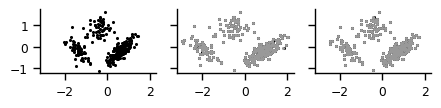

In [25]:
n_upd = upds_soln.shape[-1]
ref_pc_ = jnp.broadcast_to(ref_pc[None], (len(alt_data),) + ref_pc.shape)
updated = (ref_pc_[..., :n_upd] + upds_soln)
updated = jnp.concatenate([updated, ref_pc_[..., n_upd:]], axis=-1)
transform = updated @ jnp.swapaxes(ref_pc, -2, -1)

ref_centered = ref_data - ref_center
alt_centered = alt_data - alt_center[:, None]
transformed = transform @ jnp.swapaxes(ref_centered, -2, -1) # (batch, out, n_samples)
fig, ax = plt.subplots(1, 3, figsize = (4.5, 1.5), sharex=True, sharey=True)
ax[0].scatter(*ref_centered.T, s = 2, color = 'k')
ax[1].scatter(*alt_centered[0].T, s = 2, color = 'k')
ax[1].scatter(*transformed[0], s = 2, color ='.6')
ax[2].scatter(*alt_centered[1].T, s = 2, color = 'k')
ax[2].scatter(*transformed[1], s = 2, color ='.6')
for a in ax:
    a.set_aspect('equal')
plotter.finalize(fig, None)

### Degenerate case (no morph, circular distribution)

In [48]:
_, dataset_keypoints_degen, (_, _, _) = random_lra_2d(
    sessions = ["A", "B", "C"],
    n_frames = 3000,
    n_components = 1,
    weights = np.array([[1], [1]]) / 1,
    means = [
        [0, 0],
    ],
    covs = np.array([
        [[1, 0.], [0., 1]],
    ]) / 9,
    n_morph_dims=1,
    n_noise_dims=1,
    centroid_scale=0,
    mode_scale=0,
    ref_session = "A",
    keypoint_names = None,
    seed = 0,
)

In [55]:
ref_data = jnp.array([dataset_keypoints_degen["A"][:1000]]).reshape(-1, 2)
alt_data = jnp.array([dataset_keypoints_degen["B"][1000:2000], dataset_keypoints_degen["C"][2000:]]).reshape(2, -1, 2)
ref_pc, upds_soln, ref_center, alt_center = maximal_pc_align(ref_data, alt_data, 1, alpha = 1e-3, lr = 1e-2, max_iter = 5000, stop_window = 100, tol = 1e-8, progress = True)

  2%|▏         | 101/5000 [00:00<00:06, 747.21it/s]


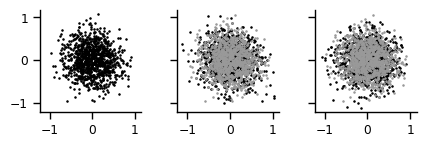

Reference PCs:
[[-0.6254881   0.780234  ]
 [ 0.7802338   0.62548804]]
Updates: (should be close to zero)
[[[-0.02212027]
  [-0.01301051]]

 [[-0.00875471]
  [-0.03132154]]]


In [56]:
n_upd = upds_soln.shape[-1]
ref_pc_ = jnp.broadcast_to(ref_pc[None], (len(alt_data),) + ref_pc.shape)
updated = (ref_pc_[..., :n_upd] + upds_soln)
updated = jnp.concatenate([updated, ref_pc_[..., n_upd:]], axis=-1)
transform = updated @ jnp.swapaxes(ref_pc, -2, -1)

ref_centered = ref_data - ref_center
alt_centered = alt_data - alt_center[:, None]
transformed = transform @ jnp.swapaxes(ref_centered, -2, -1) # (batch, out, n_samples)
fig, ax = plt.subplots(1, 3, figsize = (4.5, 1.5), sharex=True, sharey=True)
ax[0].scatter(*ref_centered.T, s = 1, color = 'k')
ax[1].scatter(*alt_centered[0].T, s = 1, color = 'k')
ax[1].scatter(*transformed[0], s = 1, color ='.6')
ax[2].scatter(*alt_centered[1].T, s = 1, color = 'k')
ax[2].scatter(*transformed[1], s = 1, color ='.6')
for a in ax:
    a.set_aspect('equal')
plotter.finalize(fig, None)

print("Reference PCs:")
print(ref_pc)
print("Updates: (should be close to zero)")
print(upds_soln)

### Place within `lowrank_affine` initialization

Key plots: scatterplots of canonicalized points throughout training (should show
learning for second run, "zeros" initialization, and well-identified components for
the first run with "covariance" initialization).

#### Project setup

In [55]:
project_config_kws, dataset_keypoints, (true_params, true_body_ids, component_ids) = random_lra_2d(
    sessions = ["A", "B", "C"],
    n_frames = 300,
    n_components = 3,
    weights = np.array([[4, 1, 1], [1, 1, 4]]) / 6,
    means = [
        [1, 0],
        [0, 1],
        [-1, 0]
    ],
    covs = np.array([
        [[1, 0.8], [0.8, 1]],
        [[1, 0], [0, 1]],
        [[1, -0.8], [-0.8, 1]],
    ]) / 9,
    n_morph_dims=1,
    n_noise_dims=2,
    centroid_scale=0.3,
    mode_scale=1,
    ref_session = "A",
    keypoint_names = None,
    seed = 0,
)
component_ids = {s: component_ids["A"] for s in dataset_keypoints}

In [56]:
# Create base project config to override

project_dir = Path('../projects/lra-init-2d')
project_dir.mkdir(exist_ok = True)
project = Project(project_dir)

plot_dir = project_dir / "plots"
plot_dir.mkdir(exist_ok = True)
plotter, colors = styles.init_nb(str(plot_dir), style = "default", fmt = 'pdf')


loaders.arrays.setup_project_config(
    project.main_config(),
    feature_type='pcs',
    alignment_type='none',
    **project_config_kws,)

setup.setup_base_model_config(project.main_config(), project.base_model_config())

#### Calibration and fitting

In [57]:
# --- calibration: alignment and feature reduction
cfg = config.load_project_config(project.main_config())
dataset = loaders.arrays.from_arrays(dataset_keypoints, cfg["dataset"])

dataset, cfg = alignment.no_alignment.calibrate(dataset, cfg)

cfg = features.pcs.calibrate(dataset, cfg, n_dims=2)
dataset = features.reduce_to_features(dataset, cfg["features"])
config.save_project_config(project.main_config(), cfg, write_calib=True)

# --- calibration: pose and morph models
cfg = config.load_model_config(project.base_model_config())
cfg["morph"]["prior_mode"] = "distance"
cfg["morph"]["init"]["type"] = "covariance"
cfg["pose"]["calibration"]["n_iter"] = 7
cfg["fit"]["n_steps"] = 100
cfg["fit"]["learning_rate"] = 1e0
cfg["fit"]["mstep"]["tol"] = None

cfg = pose.gmm.calibrate_base_model(dataset, cfg)
cfg = morph.lowrank_affine.calibrate_base_model(dataset, cfg, n_dims=1)
cfg = em.calibrate_base_model(dataset, cfg)
config.save_model_config(project.base_model_config(), cfg, write_calib=True)

INFO:root:Fitting GMM to 300 frames
INFO:root:Fitting GMM to 300 frames
INFO:root:Fitting GMM to 300 frames
INFO:root:Fitting GMM to 300 frames
INFO:root:Fitting GMM to 300 frames
INFO:root:Fitting GMM to 300 frames


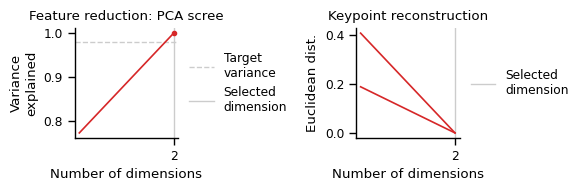

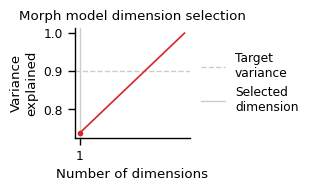

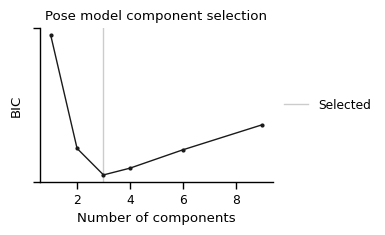

PosixPath('../projects/lra-init-2d/plots/pose_calibration.pdf')

In [58]:
cfg = config.load_model_config(project.base_model_config())

fig = features.pcs.plot_calibration(cfg)
plotter.finalize(fig, "feature_calibration")

figs = viz.model.plot_calibration(cfg)
plotter.finalize(figs["morph"], "morph_calibration")
plotter.finalize(figs["pose"], "pose_calibration")

In [59]:
scan_cfg, model_cfg = scans.setup_scan_config(project, "morph-prior-scan", {
    'morph.dist_var': [1e1, 1e1],
    'morph.init.type': ['covariance', 'zeros'],
})
cfg = config.load_project_config(project.main_config())
dataset = loaders.arrays.from_arrays(dataset_keypoints, cfg["dataset"])
scan_dataset, split_meta, _ = scans.prepare_scan_dataset(dataset, project, "morph-prior-scan", return_session_inv=True)

In [61]:
scans.run_scan(project, "morph-prior-scan", scan_dataset, log_every=20, force_restart=True)

INFO:root:Removing existing model /Users/kaifox/projects/mph/generative_api/test/projects/lra-init-2d/models/morph-prior-scan_0
INFO:root:Initializing morph model
INFO:root:Initializing pose model
INFO:root:Fitting GMM to 150 frames
INFO:root:Adjusting learning rate:1.0 -> 0.0011111111111111111
INFO:root:Loading LR schedule: const
INFO:root:Step 0 : loss = 1092.860107421875
INFO:root:Step 20 : loss = 1089.94580078125
INFO:root:Step 40 : loss = 1089.92529296875
INFO:root:Step 60 : loss = 1089.92529296875
INFO:root:Step 80 : loss = 1089.9261474609375
INFO:root:Removing existing model /Users/kaifox/projects/mph/generative_api/test/projects/lra-init-2d/models/morph-prior-scan_1
INFO:root:Initializing morph model
INFO:root:Initializing pose model
INFO:root:Fitting GMM to 150 frames
INFO:root:Adjusting learning rate:1.0 -> 0.0011111111111111111
INFO:root:Loading LR schedule: const
INFO:root:Step 0 : loss = 1214.315185546875
INFO:root:Step 20 : loss = 1089.924560546875
INFO:root:Step 40 : los

##### Standard training diagnostics

  0%|          | 0/2 [00:00<?, ?it/s]

Plotting morph-prior-scan_0
- reports


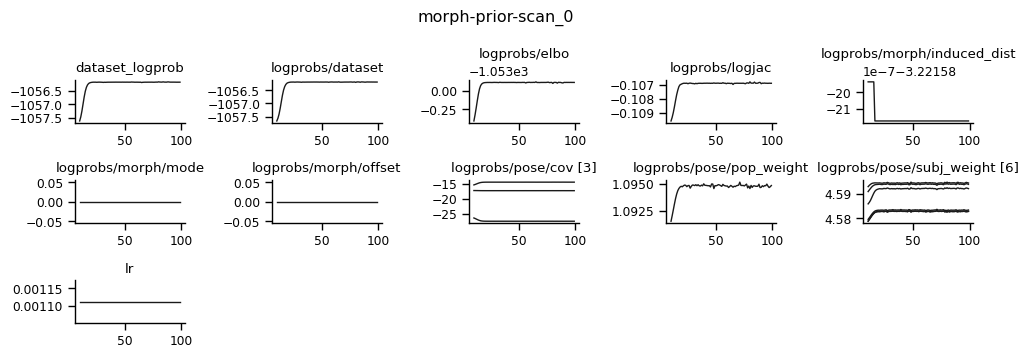

100%|██████████| 100/100 [00:00<00:00, 7849.94it/s]


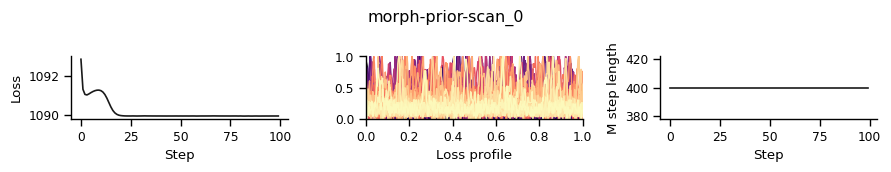

- morph


100%|██████████| 6/6 [00:00<00:00, 126.00it/s]


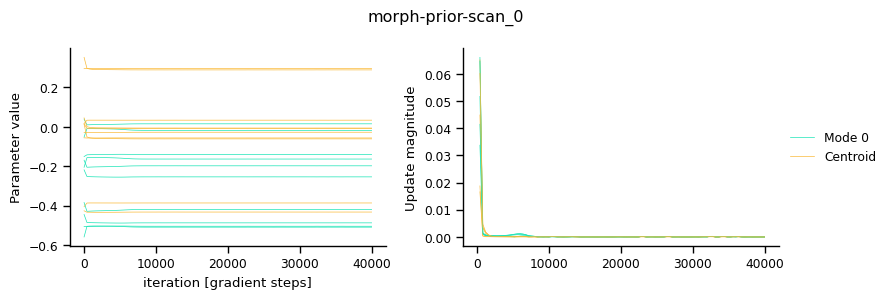

- gmm


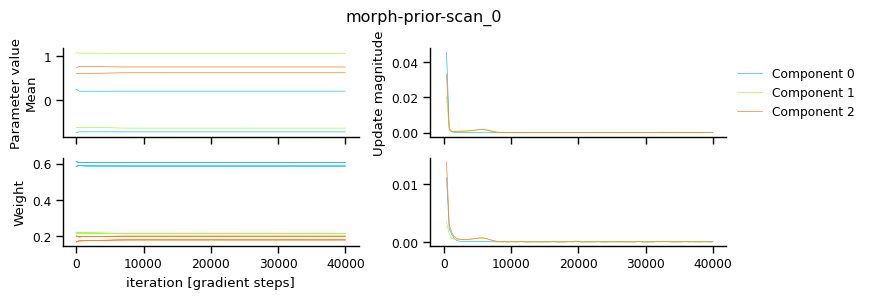

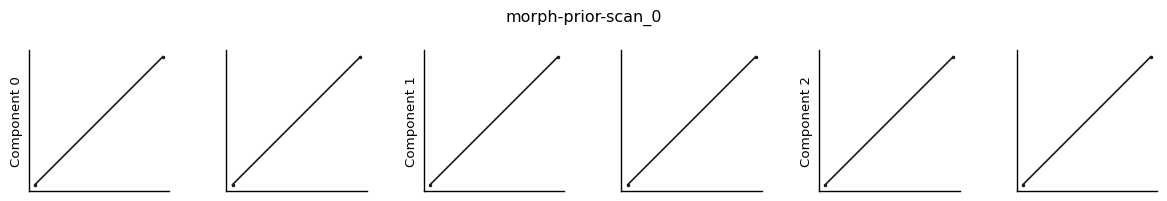

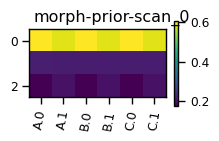

 50%|█████     | 1/2 [00:01<00:01,  1.68s/it]

Plotting morph-prior-scan_1
- reports


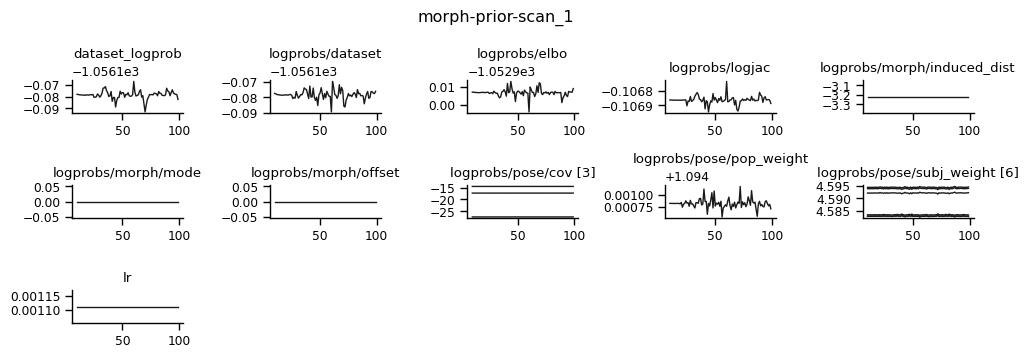

100%|██████████| 100/100 [00:00<00:00, 7713.52it/s]


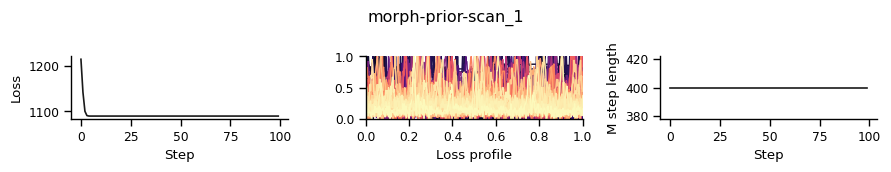

- morph


100%|██████████| 6/6 [00:00<00:00, 416.89it/s]


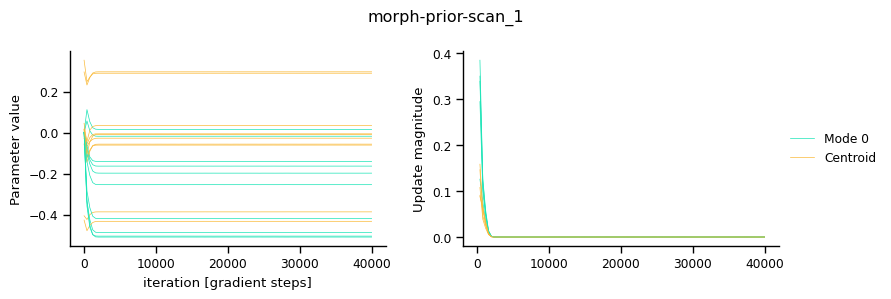

- gmm


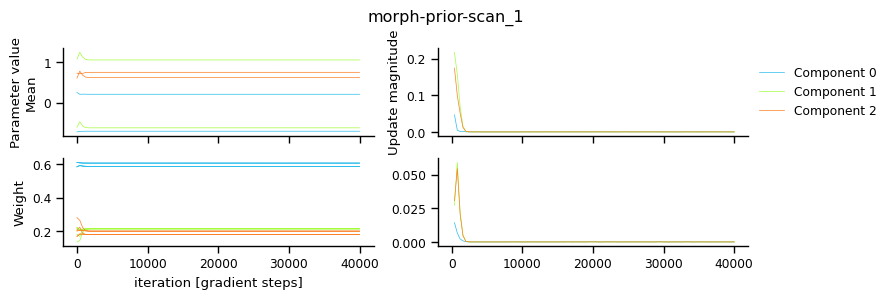

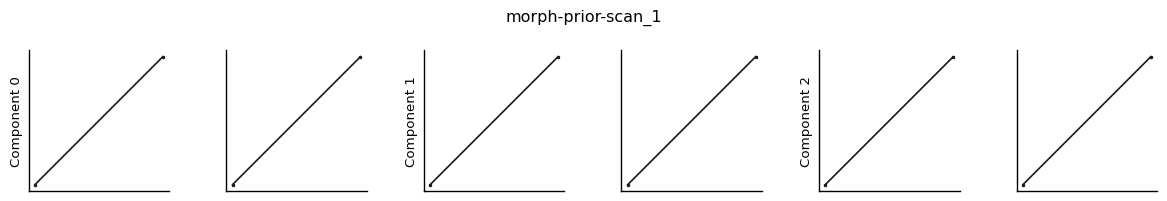

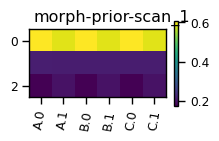

100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


In [62]:
progress = True
models = list(scan_cfg['models'].keys())

for model_name in model_util._optional_pbar(models, progress):

    print("Plotting", model_name)
    ckpt = methods.load_fit(project.model(model_name))
    ckpt["config"] = config.load_model_config(project.model_config(model_name))
    (project.model(model_name) / "plots").mkdir(exist_ok = True)
    plotter.plot_dir = str(project.model(model_name) / "plots")

    print("- reports")
    fig = viz.model.report_plots(ckpt, first_step=10, ax_size=(2, 1.2))
    fig.suptitle(model_name)
    plotter.finalize(fig, "reports")

    fig = viz.model.em_loss(ckpt)
    fig.suptitle(model_name)
    plotter.finalize(fig, "em_loss")

    print("- morph")
    fig = viz.model.lra_param_convergence(ckpt, progress = True, dataset=scan_dataset, magnitude_only=True, normalize=False)
    fig.suptitle(model_name)
    plotter.finalize(fig, "morph_convergence")

    print("- gmm")
    fig = viz.model.gmm_param_convergence(ckpt, progress = True, dataset=scan_dataset, magnitude_only=True, normalize=False)
    fig.suptitle(model_name)
    plotter.finalize(fig, "gmm_convergence")

    mean_fig, wt_fig = viz.model.gmm_components(ckpt, dataset=scan_dataset)
    mean_fig.suptitle(model_name)
    wt_fig.suptitle(model_name)
    plotter.finalize(mean_fig, "gmm_means")

##### Dataset-specific results

###### plotting functions

In [18]:
# model manipulation
def lra_anchor_poses(params: LRAParams, magnitudes=90):
    """
    Parameters:
    params (LRAParams):
        Parameters used for calculating anchor poses.
    magnitudes (float, numpy.ndarray):
        The magnitude value used in calculating anchor poses. If a float, the
        same magnitude is used for all anchors. If an array, the magnitude
        for each dimension is specified separately. Not applied to the centroid
        anchor.
    
    Returns, (array, shape (n_bodies, n_dims, n_modes + 1)):
    numpy.ndarray:
        The anchor poses in the canonical pose space.
    """

    L = params.n_dims

    if isinstance(magnitudes, (int, float)):
        magnitudes = magnitudes * np.ones(L)

    # (n_bodies, n_dims, 1)
    anchors = (params.offset + params.offset_updates).reshape(params.n_bodies, -1, 1)
    # (n_bodies, n_dims, n_modes + 1)
    anchors = np.concatenate(
        [
            anchors,
            anchors + magnitudes[None, None] * (params.modes + params.mode_updates),
        ],
        axis=-1,
    )

    return anchors

def anchor_keypoints(params: LRAParams, align_meta: dict, magnitudes=90, _inflate = None, config=None):
    """
    Calculate and return the anchor poses from a model in the original keypoint
    space. 
    
    This function computes anchor poses based on the provided parameters and
    alignment metadata, inflates the poses based on a given configuration (if
    any), and then applies inverse alignment scaling to return the poses in
    their original keypoint space. 

    Parameters:
    params, dict:
        Parameters used for calculating anchor poses.
    align_meta, dict:
        Metadata for alignment, including scaling factors.
    magnitudes, int, optional:
        The magnitude value used in calculating anchor poses. Defaults to 90.
    _inflate, function, optional:
        A custom function to inflate anchor poses. If None, a default inflation
        based on the 'features' configuration is used.
    config, dict, optional:
        Configuration dictionary that, if provided, is used to inflate the
        anchor poses using the '_inflate' function. It should contain a
        'features' key if'_inflate' is not provided. 
    
    Returns:
    numpy.ndarray, shape (n_bodies, n_anchor, n_keypt, n_spatial):
        The anchor poses in the original keypoint space after applying inverse
        alignment scaling,
    
    Note:
    This function relies on external functions `lra_anchor_poses` for
    calculating anchor poses and `alignment._inverse_align_scales` for applying
    inverse alignment scaling. It also uses a lambda function for inflation if
    '_inflate' is not explicitly provided.
    """
    if _inflate is None:
        _inflate = lambda x: features.inflate(x, config['features'])
    anchor_poses = lra_anchor_poses(params, magnitudes)  # (n_session, n_feat, n_anch)
    inflated = _inflate(anchor_poses.transpose(0, 2, 1))
    if "scale" in align_meta:
        return alignment._inverse_align_scales(
            inflated, align_meta["scale"][:, None], stacked=True
        )
    else:
        return inflated

def anchor_magnitudes(dataset: Dataset, params: LRAParams, q=0.9, canonicalized=False):
    """
    Sample the `q`th percentile in absolute value from distributions of anchor
    pose coordinates.

    dataset : Dataset
        Feature data, in canonical pose space if `canonicalized` is True.
    model : MorphModel
    params : LRAParams
    """
    if canonicalized:
        canonical = dataset.data
    else:
        canonical = model_util.apply_bodies(
            lra_model,
            params,
            dataset,
            {s: dataset.session_body_name(dataset.ref_session) for s in dataset.sessions},
        ).data

    coords = canonical @ params.modes  # (n_pts, n_modes)
    qix = jnp.argsort(abs(coords), axis=0)[int(coords.shape[0] * q)]  # argquantile
    selected_coord = coords[qix, jnp.arange(coords.shape[1])]
    return selected_coord



def plot_dataset_2d(sessions, n_components, raw_data, component_ids, ax=None, titles=True, **kws):
    global colors
    component_pal = np.array(colors.cts(n_components))
    nsess = len(sessions)
    ncol = min(4, nsess)
    fig = None
    if ax is None:
        fig, ax, grid = viz.util.flat_grid(nsess, ncol, (2, 2), sharex=True, sharey=True)
    for a, s in zip(ax, sessions):
        if component_ids is not None:
            c = component_pal[component_ids[s]]
        else:
            c = 'k'
        a.scatter(*raw_data[s][..., 0].T, c=c, **{**dict(s=4, lw=0), **kws})
        if titles:
            a.set_title(s)
        a.set_aspect(1.)
    return fig, ax


def plot_canonical_steps_2d(
    plot_iters,
    project,
    model_name,
    scan_dataset
):
    # plot_iters = [0, 10, 'final']

    ckpt = methods.load_fit(project.model(model_name))
    model = instantiation.get_model(ckpt["config"])
    nsess = len(scan_dataset.sessions)
    fig, ax = plt.subplots(len(plot_iters), nsess, figsize=(2 * nsess, 1.5 * len(plot_iters)), sharex=True, sharey = True)
    if len(plot_iters) == 1:
        ax = ax[None]
    component_pal = np.array(colors.cts(ckpt['params'].pose.n_components))
    for row, plot_iter in enumerate(plot_iters):
        if isinstance(plot_iter, int):
            step_params = scans.select_param_step(
                model, ckpt["params"], ckpt["meta"]["param_hist"], plot_iter
            )
            ax[row, 0].set_ylabel(f"Iteration {plot_iter}")
        else:
            step_params = ckpt["params"]
            ax[row, 0].set_ylabel("Final")
        canonicalized = model_util.apply_bodies(
            model.morph,
            step_params.morph,
            scan_dataset,
            {s: scan_dataset.session_body_name(scan_dataset.ref_session) for s in scan_dataset.sessions},
        )
        step_compon_ids = get_component_assignments(
            canonicalized,
            model.pose,
            step_params.pose,
        )
        for i, sess in enumerate(scan_dataset.sessions):
            ax[row, i].scatter(
                *pad_to_2d_noise(canonicalized.get_session(sess).T),
                c=component_pal[step_compon_ids.get_session(sess)],
                s=4,
                lw=0,
            )
            if row == 0:
                ax[row, i].set_title(sess)
                if sess == scan_dataset.session_name(scan_dataset.ref_session):
                    ax[row, i].set_title(sess + ' (ref)')
                
        for a in ax[row]:
            for i_comp in range(3):
                a.scatter(
                    *pad_to_2d_zero(step_params.pose.means[i_comp, None].T),
                    c=[component_pal[i_comp]],
                    marker="s",
                    edgecolor='w',
                    lw=0.5,
                    s=30,
                    label = f"{i_comp}"
                )
            a.set_aspect("equal")
        ax[row, 0].set_xlim(-3, 3)
        ax[row, 0].set_ylim(-2, 2)
    viz.util.legend(ax[0, -1])
    fig.suptitle(model_name)
    return fig

def get_component_assignments(
    poses_dataset,
    pose_model,
    params
):
    logp = pose_model.pose_logprob(params, poses_dataset)
    return poses_dataset.update(data = jnp.argmax(logp, axis = -1))

def pad_to_2d_zero(x):
    pad = np.zeros((2 - x.shape[0],) + x.shape[1:])
    return np.concatenate([x, pad], axis=0)
def pad_to_2d_noise(x):
    pad = np.random.randn(*((2 - x.shape[0],) + x.shape[1:]))
    padded = np.concatenate([x, pad], axis=0)
    return padded

def plot_anchors_2d(
    ax,
    params,
    body_ids,
    pal=None,
    magnitudes=1,
    _inflate=lambda x: x,
    align_meta={},
    anchors=None,
    **kws,
):
    if anchors is None:
        anchors = anchor_keypoints(
            params, align_meta, magnitudes=magnitudes, _inflate=_inflate
        )
    n_anch = anchors.shape[1]
    if pal is None:
        pal = np.array(list(Colormap("tab10_new").iter_colors(n_anch)))[::-1]
    for i_anch in range(n_anch):
        for i_b, b in enumerate(body_ids):
            anch = anchors[b, i_anch]
            ax[i_b].plot(
                [anch[0]],
                [anch[1]],
                **{
                    **dict(
                        lw=0, marker='o', color=pal[i_anch], ms=5, mew=1, mec="k"
                    ),
                    **kws,
                },
            )

def plot_anchor_steps_2d(
    plot_iters,
    project,
    model_name,
    scan_dataset,
    n_components=3,
    magnitudes=1,
):
    """
    Displays true component assignments not those inferred from the model
    No inverse alignment (including scale normalization) is applied
    """

    ckpt = methods.load_fit(project.model(model_name))
    cfg = ckpt['config']
    model = instantiation.get_model(ckpt["config"])
    nsess = len(scan_dataset.sessions)
    fig, ax = plt.subplots(len(plot_iters), nsess, figsize=(2 * nsess, 1.5 * len(plot_iters)), sharex=True, sharey = True)
    if len(plot_iters) == 1:
        ax = ax[None]
    
    sessions = list(scan_dataset.sessions)
    body_ids = [scan_dataset.session_body_id(s) for s in scan_dataset.sessions]
    _inflate = lambda x: features.inflate(x, cfg['features'])
    dset_keypoints = _inflate(scan_dataset)
    dset_keypoints = {s: dset_keypoints.get_session(s) for s in sessions}
    
    for row, plot_iter in enumerate(plot_iters):
        if isinstance(plot_iter, int):
            step_params = scans.select_param_step(
                model, ckpt["params"], ckpt["meta"]["param_hist"], plot_iter
            )
            ax[row, 0].set_ylabel(f"Iteration {plot_iter}")
        else:
            step_params = ckpt["params"]
            ax[row, 0].set_ylabel("Final")

        
        plot_dataset_2d(sessions, n_components, dset_keypoints, None, ax = ax[row])
        plot_anchors_2d(ax[row], step_params.morph, body_ids, magnitudes=magnitudes, _inflate=_inflate)

    for a in ax.ravel():
        a.set_aspect(1.)

    fig.suptitle(model_name)
    return fig, ax

###### diagnostics

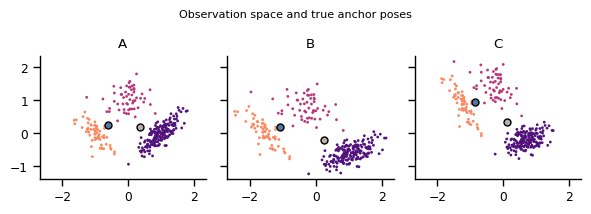

In [60]:
fig, ax = plot_dataset_2d(["A", "B", "C"], 3, dataset_keypoints, component_ids)

plot_anchors_2d(ax, true_params, [true_body_ids[s] for s in "ABC"], magnitudes=1)
fig.suptitle("Observation space and true anchor poses", fontsize=8)

plotter.finalize(fig, None)

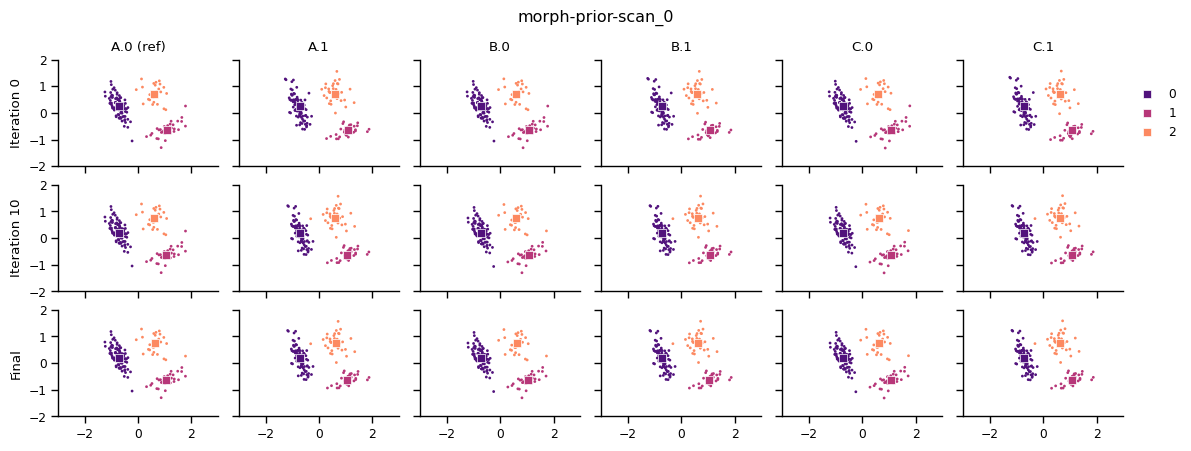

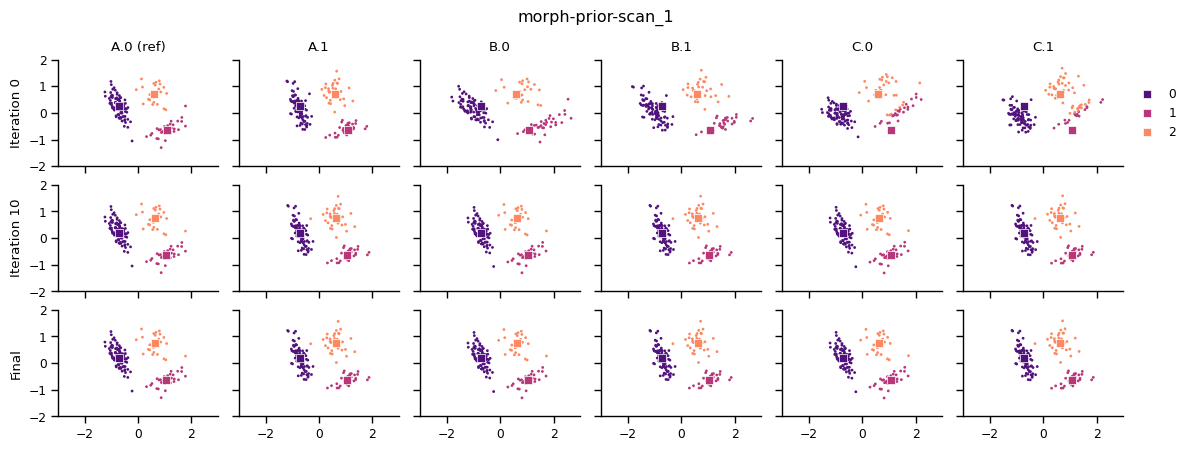

In [63]:
for model_name in models:
    fig = plot_canonical_steps_2d(
        [0, 10, 'final'],
        project,
        model_name,
        scan_dataset
    )
    plotter.finalize(fig, None)

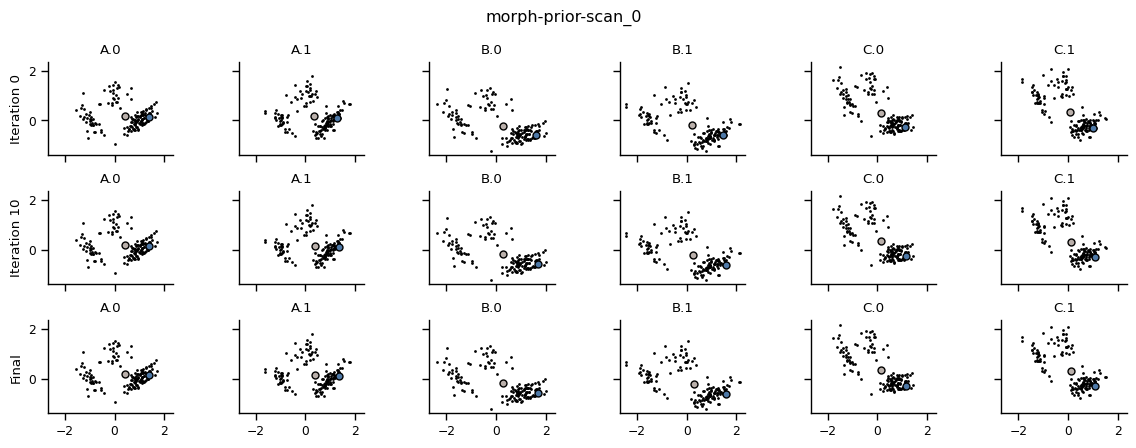

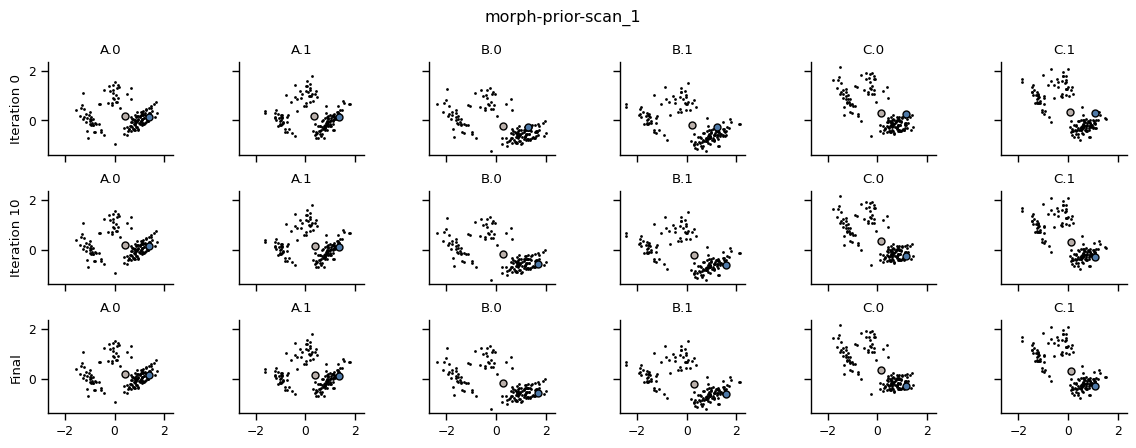

In [70]:
# Full session data in color
# Inflated data from `scan_dataset` in black
# Anchor poses large colored dots

for model_name in models:

    fig, ax = plot_anchor_steps_2d(
        [0, 10, "final"],
        project,
        model_name,
        scan_dataset,
    )
    plotter.finalize(fig, None)
